### 4MAT 테스트 분석 | 2019.08

4MAT테스트? 세계적인 교육학자 버니스 매카시가 고안한 사고진단프로그램으로, 설문을 통해 4가지 유형으로 분류  
익명의 지인(?) 11명 설문조사 후 결과를 분석해보자 

- 4MAT 세그먼트 분류 : 동그라미(시인형), 네모(과학자형), 세모(기술자형), 별(창업가형). 노트북 맨끝의 설명 이미지를 참조하자~!
- 구글 Colab에서 작성
- 4MAT 안내페이지(큰 도움 안됨) : http://changemakers.co.kr/edu/edu4Mat
- 설문페이지 예시(실제와 다름) : http://aboutlearning.dk/minitest_UK/resultat-type.html

#### 분석환경 세팅(구글 Colab)

In [0]:
import re 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip3 install seaborn==0.9.0
import seaborn as sns
print(sns.__version__)   # seaborn 최신버전 깔자(기본 설치버전은 0.7)
plt.style.use('ggplot')  

# Suppress Deprecation and Incorrect Usage Warnings 
import warnings
warnings.filterwarnings('ignore')

In [0]:
# 구글 Colab에서만 필요

# 나눔고딕 폰트 설치
!apt-get install fonts-nanum*
!apt-get install fontconfig
!fc-cache -fv
!cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm -rf /content/.cache/matplotlib/*
  
  # 한글 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
	
  
# 나눔 고딕으로 설정을 바꾼다
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='NanumGothic')
  
mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스 폰트 깨질 경우 대비

#### 데이터 전처리

In [0]:
# 결과값 입력
mat = [['hanho',44,40,36,30,-9],
       ['deukhwan',18,38,43,51,7],
       ['inhee',31,46,38,35,-5],
       ['kyunam',36,45,29,40,-3],
       ['hahnduck',23,44,33,51,-11],
       ['hongchul',22,51,44,33,-5],
       ['daebok',33,28,33,56,11],
       ['seungmok',51,30,29,40,1],
       ['juhee',25,41,50,34,-1],
       ['gyeeun',22,46,43,39,-7],
       ['yejee',29,32,45,44,5]]
df_mat = pd.DataFrame(mat)
df_mat.columns = ['이름','동그라미','네모','세모','별','doing_score']

In [0]:
# 검산 : 점수합계가 각각 150되는지
df_mat.iloc[:,1:5].sum(axis=1)  # => OK

---
#### 분석 과정 및 주제 
1. 피처 추가 : 대표세그먼트 만들기, 표준편차
2. 세그먼트 분석 : 건수 집계, 세그먼트별 점수 총점/분포(박스플롯), 상관계수
3. 개인별 분석 : 레이더 차트, 표준편차, MDS
4. 진단표 이미지 첨부, 시사점 정리(웹 플랫폼 있으면 좋겠다)

In [0]:
# 피처 추가 : 개인별 최고점수에 대표 세그먼트 넣기
arr = df_mat.iloc[:,1:5].values  # 점수만 array로
max_pos = np.argmax(arr, axis=1) # 최대값 자릿수 찾기
cols = df_mat.columns[1:5] 
df_mat['segment'] = pd.Series([ cols[i] for i in max_pos ])

# 피처 추가 : 점수별 표준편차(4개 세그먼트별 점수가 고르게 분포 되었으면 표준편차가 작다)
df_mat['std'] = pd.Series(np.std(arr, axis=1))
df_mat

,이름,동그라미,네모,세모,별,doing_score,segment,std
0,hanho,44,40,36,30,-9,동그라미,5.172040
1,deukhwan,18,38,43,51,7,별,12.175796
2,inhee,31,46,38,35,-5,네모,5.500000
3,kyunam,36,45,29,40,-3,네모,5.852350
4,hahnduck,23,44,33,51,-11,별,10.662434
5,hongchul,22,51,44,33,-5,네모,11.011358
6,daebok,33,28,33,56,11,별,10.874282
7,seungmok,51,30,29,40,1,동그라미,8.902247
8,juhee,25,41,50,34,-1,세모,9.178780
9,gyeeun,22,46,43,39,-7,네모,9.287088


#### 세그먼트 분석 : 건수 집계, 세그먼트별 점수 총점/분포(박스플롯), 상관계수

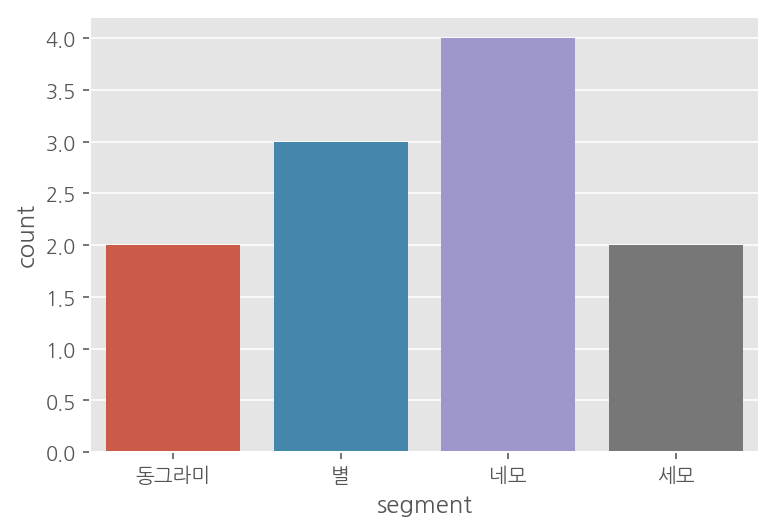

In [0]:
# 10명의 세그먼트 집계
sns.countplot(x='segment', data=df_mat)

네모(과학자형)와 별(창업가형)이 가장 많다.  
반면 동그라미(시인형)은 딱 한명!

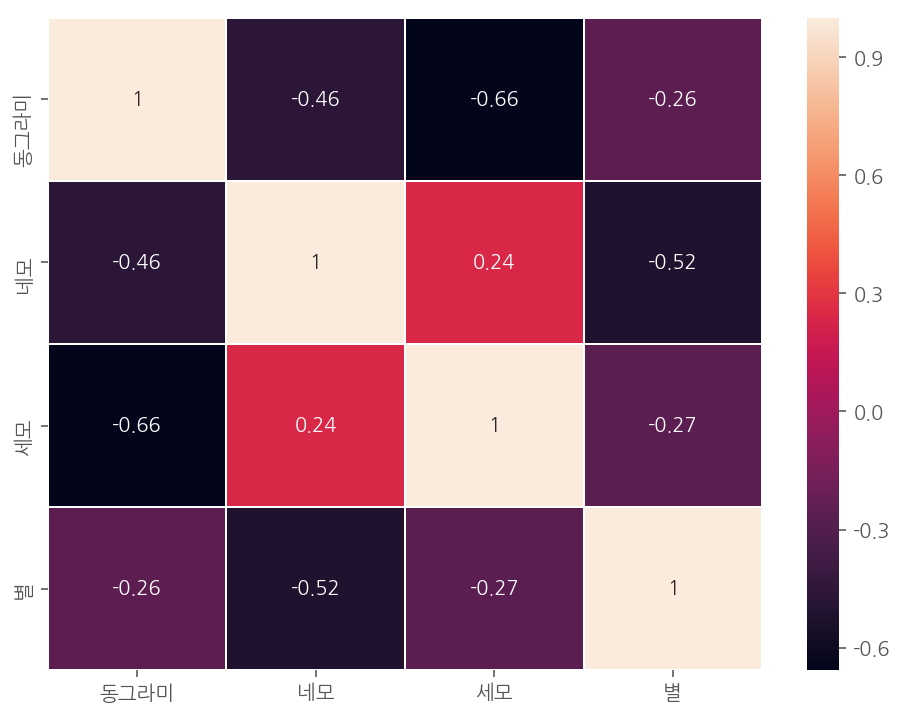

In [0]:
# 점수간의 상관분석
corr = df_mat.iloc[:,1:5].corr()

plt.figure(figsize=(8,6))
ax = sns.heatmap(corr, annot=True, linewidths=0.5)

별(창업가형) 점수는 다른 세그먼트와 강한 음의 상관관계를 보인다.  
이는 별 유형이 다른 유형과는 상당히 틀린 성향을 보인다는 것을 알 수 있다. 


#### 개인별 분석 : 레이더 또는 바(복합구성), 표준편차, MDS

In [0]:
# 레이더 차트(코드소스) : https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
from math import pi
 
# 소스코드의 데이터 구성은 이렇다. 
# 동일하게 맞춰야 차트 함수 구현됨
'''
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
'''

def make_spider(row, title, color): 
  # number of variable
  categories=list(df)[1:]
  N = len(categories)

  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]

  # Initialise the spider plot
  ax = plt.subplot(4,3,row+1, polar=True, )  ### 차트 수만큼 subplot수를 맞춰준다. 

  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)

  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories, color='grey', size=8)

  # Draw ylabels
  ax.set_rlabel_position(0)
  plt.yticks([10,20,30,40,50,60], ["10","20","30","40","50","60"], color="grey", size=7)
  plt.ylim(0,60)

  # Ind1
  values=df.loc[row].drop('group').values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
  ax.fill(angles, values, color=color, alpha=0.4)

  # Add a title
  plt.title(title, size=11, color=color, y=1.1)

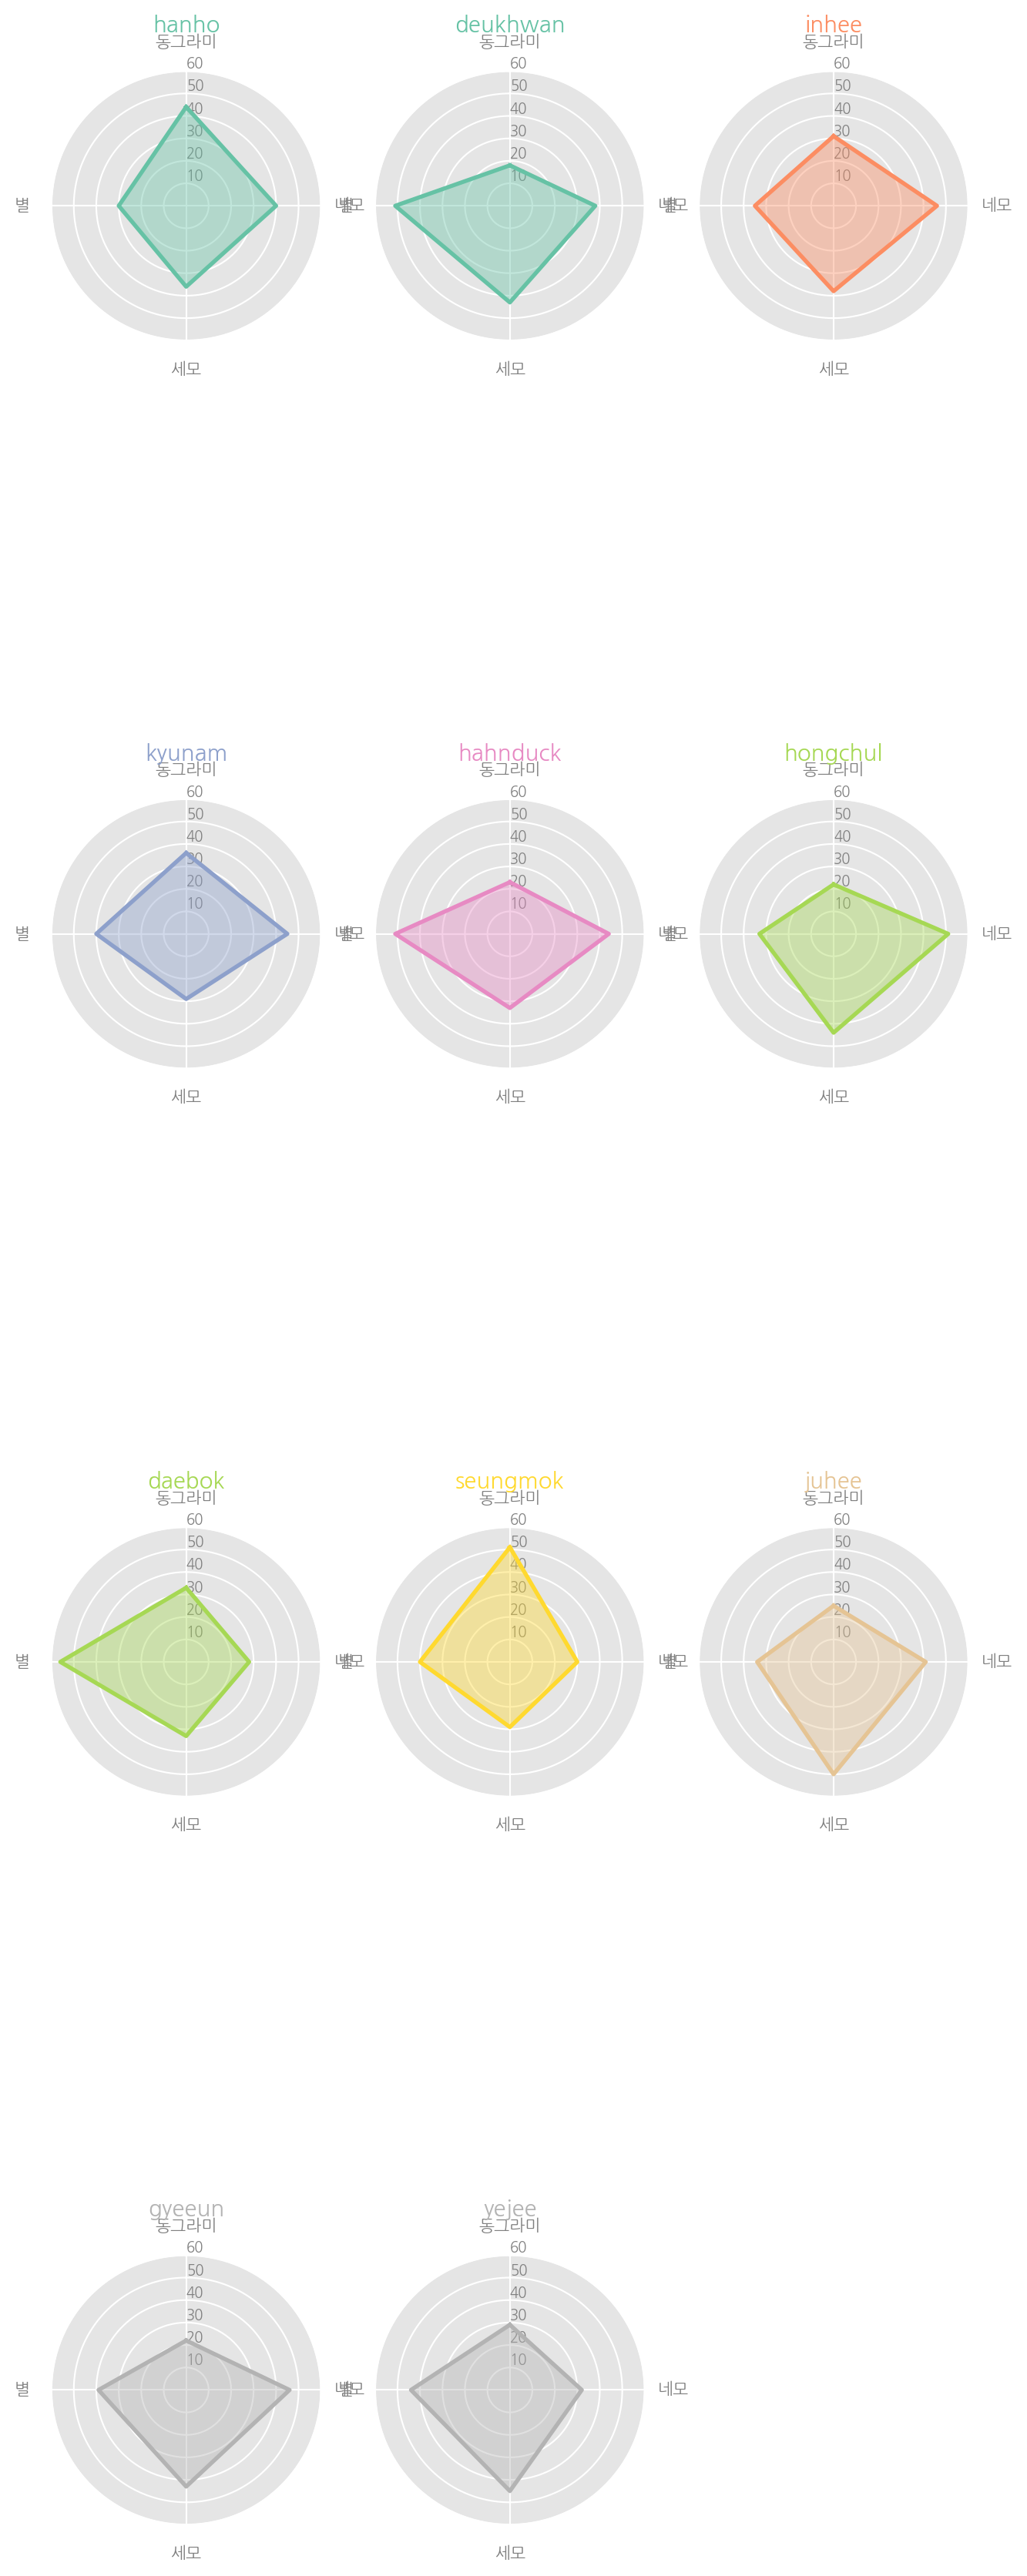

In [0]:
# 개인별 차트를 돌려보자
df = df_mat.iloc[:,:5].rename(columns={'이름':'group'}) 

my_dpi=96   # 해상도
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.figure(figsize=(8,25), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))

# Loop to plot
for row in range(0, len(df.index)):
  # make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
  make_spider(row=row, title=df['group'][row], color=my_palette(row))

11명 모두 각기 다른 특성을 보인다.  
해석시 주의할 점은 세그먼트 점수는 하나의 특성일 뿐, 우열은 아니라는 것~! 

In [0]:
# 4개 유형 점수별 표준편차도 살펴보자.
# 표준편차가 크면 특정 세그먼트에 집중되어 있는 것~! 
# 반대로 작다면, 여러 세그먼트 성향이 섞여 있는 것~! 
df_mat.head()

,이름,동그라미,네모,세모,별,doing_score,segment,std
0,hanho,44,40,36,30,-9,동그라미,5.172040
1,deukhwan,18,38,43,51,7,별,12.175796
2,inhee,31,46,38,35,-5,네모,5.500000
3,kyunam,36,45,29,40,-3,네모,5.852350
4,hahnduck,23,44,33,51,-11,별,10.662434


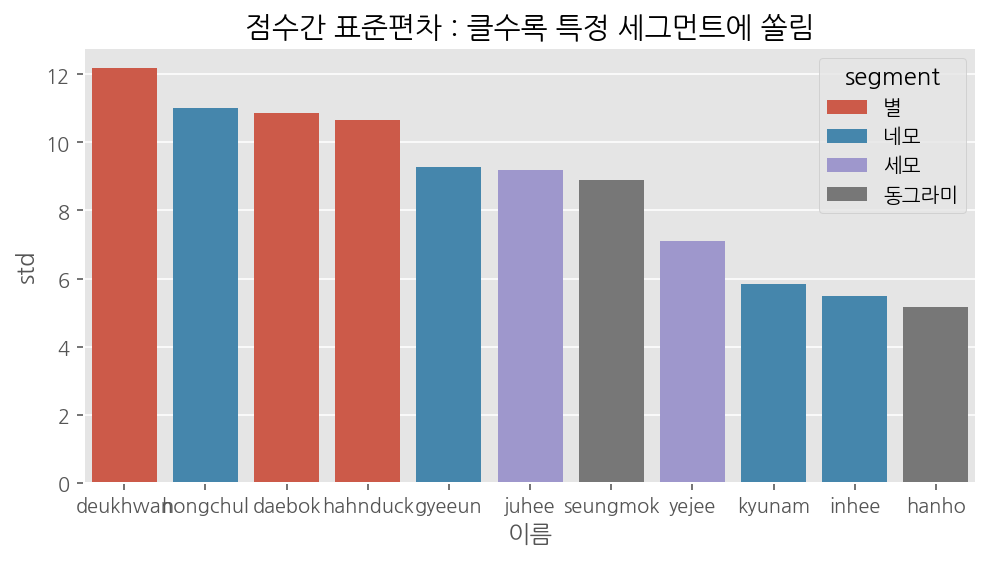

In [0]:
# dodge 명령어는 seaborn 0.9 이상에서 지원(segment별로 색깔 줄 때 필요, hue)
plt.figure(figsize=(8,4))
ax = sns.barplot(x='이름', y='std', 
                 hue='segment', dodge=False,
                 data=df_mat.sort_values(by='std', ascending=False))
plt.title('점수간 표준편차 : 클수록 특정 세그먼트에 쏠림');

빨간색으로 표현된 별 세그먼트가 표준편차가 크다.  
이는 별 유형은, 다른 유형의 특징은 적으며 별 특유의 순도가 상당히 강하다고 볼 수 있다.  
표준편차가 작으면 여러 세그먼트 유형을 복합적으로 보유하고 있는 것으로 해석

#### 다차원 척도법으로 개인간의 유사도를 시각화해보자

4개 유형 점수로 유사도를 계산하고 2차원으로 데이터를 축소하여 차트로 구현  
다차원척도법 참고 : https://goo.gl/nHHKNG  

In [0]:
txt = \
"""
3	1	2	4	2	4	3	1	4	3	2	1	1	2	4	3	3	2	1	4	3	2	1	4	1	4	3	2	3	4	2	1	2	4	3	1	4	3	1	2	4	3	1	2	4	2	3	1	3	4	1	2	3	4	1	2	2	3	4	1
3	1	4	2	3	1	2	4	3	1	4	2	3	4	1	2	3	4	2	1	4	2	1	3	1	2	3	4	1	2	3	4	2	1	3	4	1	4	3	2	4	2	1	3	1	2	3	4	3	4	2	1	3	2	1	4	1	2	3	4
4	2	1	3	1	3	2	4	2	1	4	3	3	2	1	4	2	3	1	4	4	2	3	1	1	4	3	2	2	3	4	1	2	4	1	3	2	3	1	4	2	3	1	4	1	2	4	3	1	4	3	2	4	3	1	2	1	3	4	2
4	1	2	3	3	4	1	2	4	1	3	2	1	2	4	3	3	4	1	2	3	4	1	2	4	3	1	2	2	1	3	4	3	4	1	2	3	2	1	4	3	4	1	2	1	2	3	4	2	4	1	3	4	3	1	2	3	4	1	2
4	2	3	1	4	3	2	1	3	1	4	2	3	2	1	4	4	3	2	1	4	3	1	2	1	2	3	4	1	2	3	4	3	2	1	4	1	4	2	3	3	4	1	2	4	3	2	1	4	3	2	1	3	2	1	4	3	2	1	4
4	3	2	1	1	4	2	3	2	1	4	3	3	2	1	4	3	2	4	1	3	2	1	4	1	3	4	2	1	2	3	4	2	3	1	4	3	4	2	1	3	4	1	2	2	1	4	3	1	4	3	2	4	1	2	3	1	4	2	3
3	2	4	1	4	1	3	2	4	3	2	1	1	4	3	2	4	3	2	1	4	1	3	2	1	3	2	4	1	2	3	4	3	4	1	2	3	1	2	4	3	2	1	4	3	4	2	1	4	2	3	1	3	2	1	4	3	1	2	4
3	1	2	4	2	1	4	3	1	3	2	4	1	3	4	2	2	3	1	4	2	3	4	1	1	2	4	3	4	1	2	3	4	3	1	2	4	3	1	2	2	1	4	3	3	1	4	2	3	1	2	4	3	1	2	4	4	2	1	3
4	1	3	2	1	3	2	4	4	2	3	1	3	2	1	4	3	1	4	2	2	3	1	4	1	3	4	2	1	2	3	4	2	1	4	3	2	1	4	3	2	3	1	4	3	1	2	4	3	2	4	1	4	3	1	2	2	4	3	1
4	1	3	2	3	4	2	1	4	1	2	3	4	1	2	3	3	4	1	2	4	2	1	3	1	4	3	2	1	2	3	4	2	1	3	4	1	4	3	2	3	2	1	4	1	2	4	3	3	4	2	1	4	3	1	2	2	3	4	1
1	4	2	3	4	1	2	3	4	1	3	2	4	3	1	2	1	4	3	2	2	3	1	4	1	4	3	2	1	2	4	3	3	4	2	1	2	3	1	4	4	2	1	3	3	2	4	1	3	4	2	1	1	2	4	3	4	1	2	3
"""

txt = re.sub('[\n\t1]','',txt)
array = np.array(list(txt), np.int32).reshape((11,45))

df = pd.DataFrame(array, index=df_mat['이름']) #----> 인덱스 붙이고, 파일 이름 정의할 것 

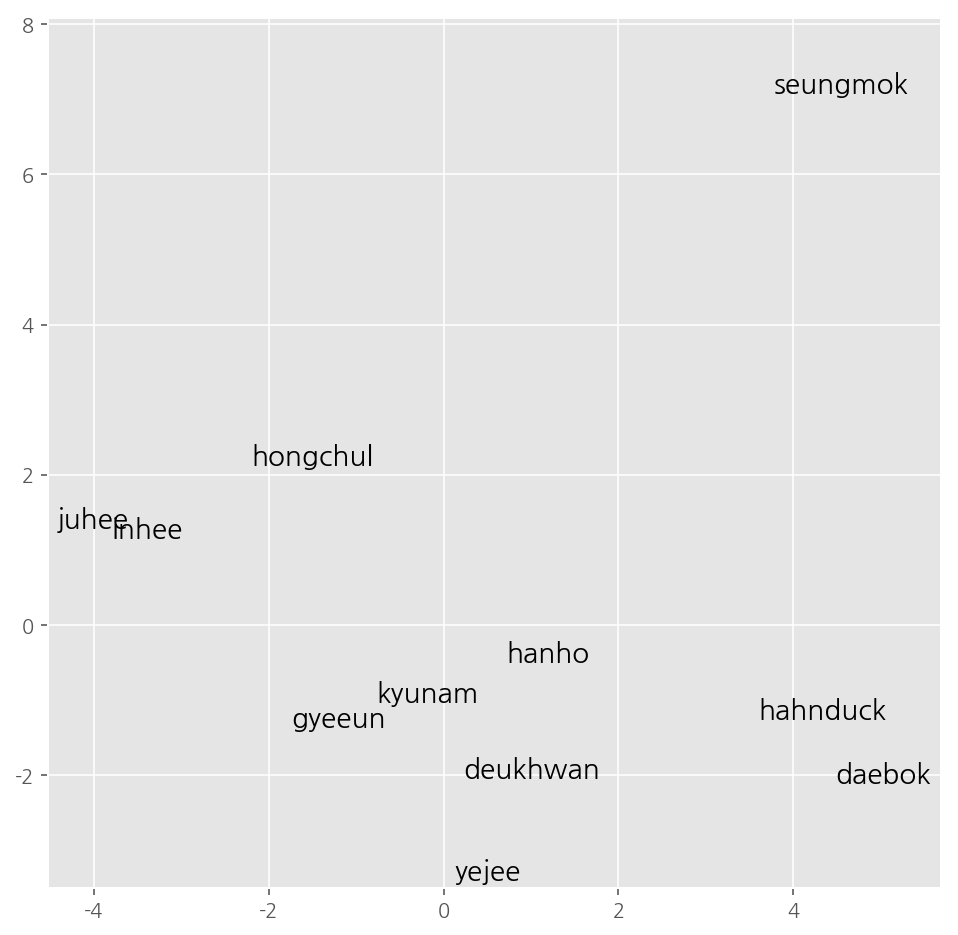

In [18]:
# 정규분포로 스케일 조정
from sklearn.preprocessing import StandardScaler    # 피처별로 스케일 다른 경우 반드시 표준화한다. 
from sklearn.decomposition import PCA               # PCA

X = df.values 
targets = df.index.values 

X_norm = StandardScaler().fit(X).transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit(X_norm).transform(X_norm)

xmax, ymax = np.amax(X_pca, axis=0)
xmin, ymin = np.amin(X_pca, axis=0)

plt.figure(figsize=(8,8))
for i in range(len(X_pca)):
  x = X_pca[i,0]
  y = X_pca[i,1]
  t = targets[i] 
  plt.text(x, y, t, fontsize=14)
  
# 최대값, 최소값에서 공간 더 마련하기
plt.xlim(xmin-0.1, xmax+1.2)
plt.ylim(ymin-0.1, ymax+1)
plt.show()

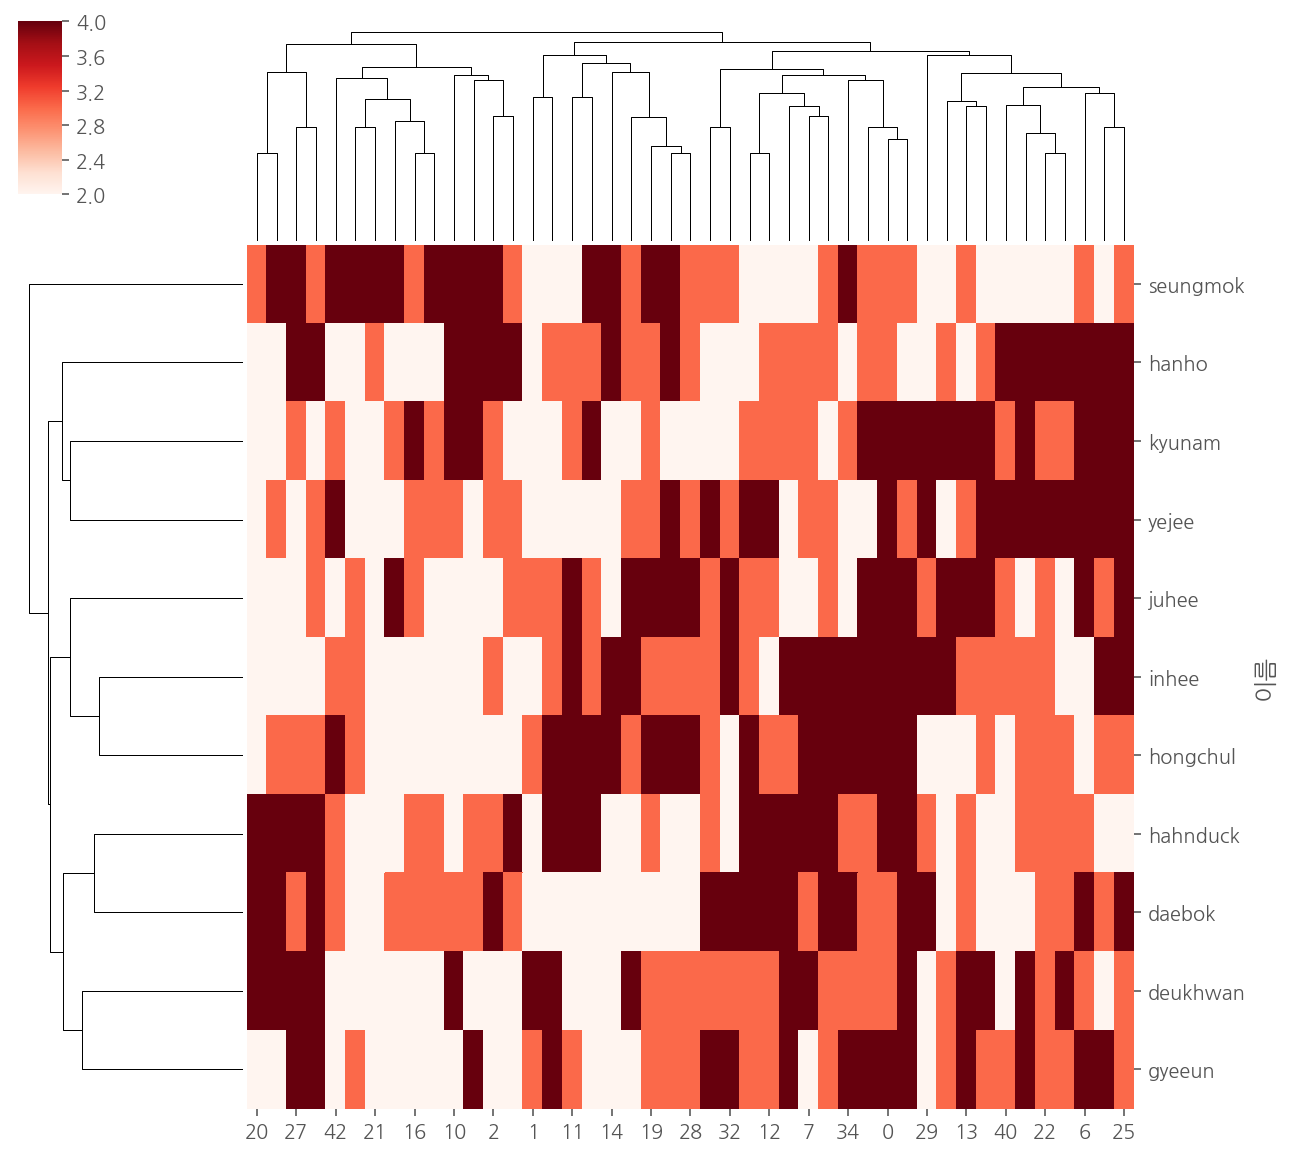

In [13]:
g = sns.clustermap(df, 
                   yticklabels=df.index.values,
                   cmap='Reds')